In [1]:
import pandas as pd
PATH = "rijs_iML1515_AMN.csv"
all_data = pd.read_csv(PATH, encoding="utf-8")
all_data_norm = (all_data - all_data.mean()) - all_data.std()
all_data

,EX_pi_e_i,EX_co2_e_i,EX_fe3_e_i,EX_h_e_i,EX_mn2_e_i,EX_fe2_e_i,EX_zn2_e_i,EX_mg2_e_i,EX_ca2_e_i,EX_ni2_e_i,...,PFK,PGI_for,PGK_rev,PGM_rev,PPC,PPCK,PTAr_for,PYK,SUCDi,TALA_for
0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,1.61,1.48,3.50,3.50,0.45,0.74,0.11,3.34,1.18,0.11
1,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,1.68,1.54,3.57,3.57,0.49,0.92,0.03,3.51,1.09,0.12
2,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,1.59,1.40,3.34,3.34,0.39,0.90,0.15,3.45,1.10,0.13
3,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,1.69,1.63,3.68,3.68,0.38,0.82,0.04,3.68,1.67,0.07
4,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,2.17,1.99,4.50,4.50,0.57,1.03,0.05,4.48,1.99,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,5.78,5.20,12.65,12.65,2.56,0.31,4.79,8.98,1.26,0.44
124,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,5.27,4.56,11.09,11.09,2.43,0.60,4.16,8.06,0.87,0.48
125,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,5.31,4.68,11.63,11.63,1.91,0.25,4.94,8.72,0.90,0.45
126,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,6.69,5.93,13.76,13.76,2.61,0.32,5.81,10.16,1.10,0.51


In [2]:
X = all_data_norm.iloc[:,:89].values
Y = all_data_norm.iloc[:,89:].values
print(X.shape, Y.shape)

(128, 89) (128, 31)


In [3]:
# XGBoost
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn
import xgboost as xgb # must be in AMN_windows env
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, List

In [4]:
LOO_split = int(Y.shape[0])

xgb_preds = []

for i in range(5):

    # XGBoost = xgb.XGBRegressor(n_estimators=600, max_depth=2, learning_rate=0.01, objective='reg:squarederror', random_state=i)
    multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror'))

    xgb_pred = cvp(multioutputregressor, X, Y, cv=KFold(n_splits=10, shuffle=True, random_state=i), n_jobs = 5)
    
    xgb_preds.append(xgb_pred)

In [5]:
mean_xgb_pred = np.array(xgb_preds).mean(axis=0)
std_xgb = np.array(xgb_preds).std(axis=0)

print(np.mean((mean_xgb_pred - Y)**2, axis=0)) # MSE between mean prediction (over 5 times 10-fold test sets) and true

print(r2_score(Y, mean_xgb_pred, multioutput='variance_weighted'))

[0.37761516 0.2614593  0.2614593  0.00208223 0.2614593  0.03936417
 0.03936417 1.30075689 0.28681028 0.25505892 0.43646565 0.35893527
 0.23195814 1.50955028 0.0244261  0.24321531 0.04650644 0.04650644
 0.22712661 0.03696281 0.76762215 0.35893527 0.31150537 1.50955028
 1.50955028 0.11830319 0.02746515 0.37761516 0.7798031  0.23195814
 0.00271557]
0.9103711369868147


<AxesSubplot:>

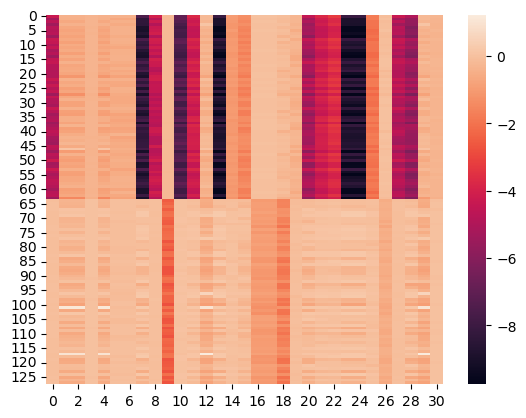

In [6]:
sns.heatmap(mean_xgb_pred)

<AxesSubplot:>

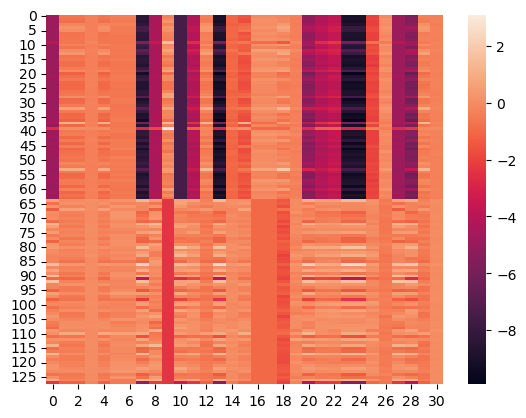

In [7]:
sns.heatmap(Y)

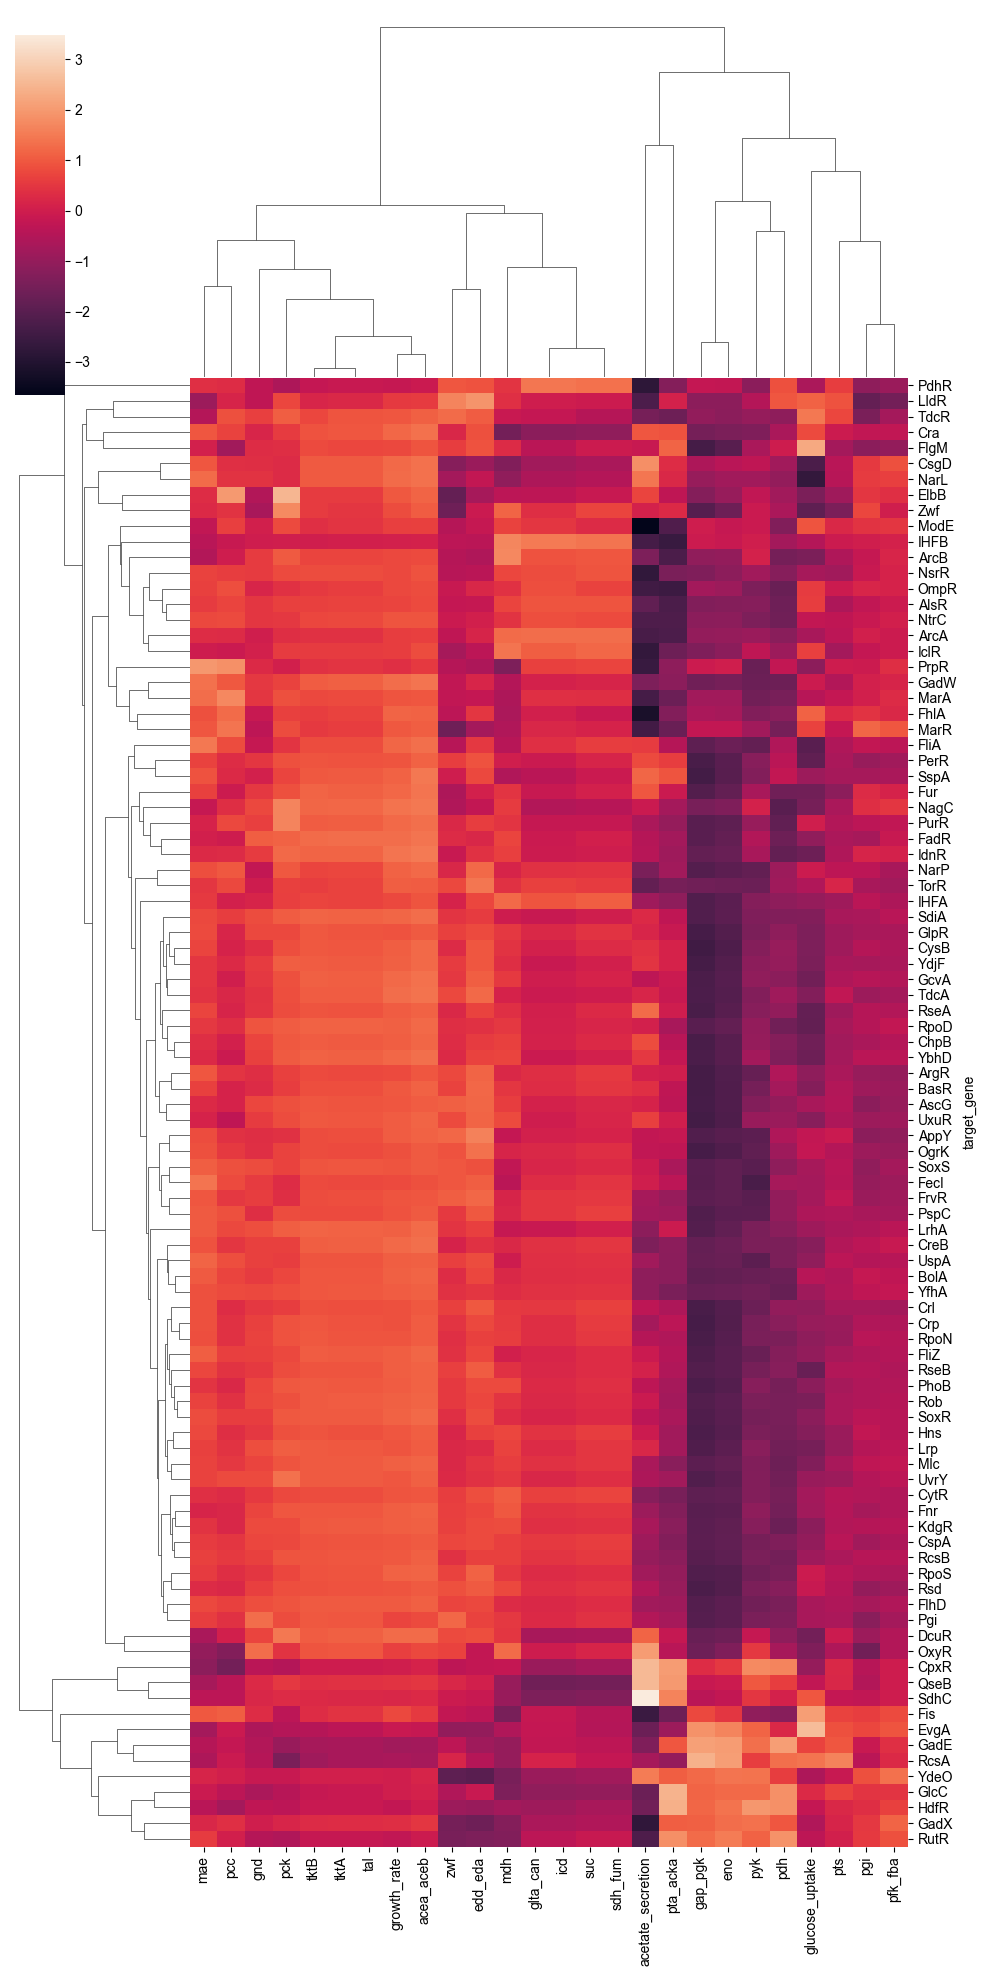

In [3]:
plt.close('all')
clustergrid = sns.clustermap(all_data_norm, z_score=0, figsize=(10,20), yticklabels=True)
ordered_fluxes_indices = clustergrid.dendrogram_col.reordered_ind
ordered_genes_indices = clustergrid.dendrogram_row.reordered_ind
sns.set_theme(palette="colorblind")
plt.show()

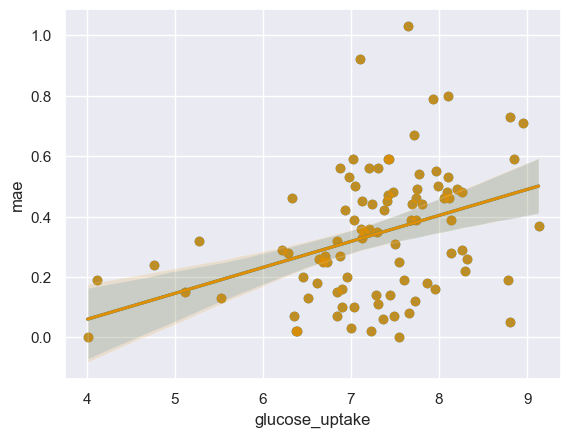

In [9]:
sns.regplot(data=all_data, x="glucose_uptake", y="mae")
plt.show()

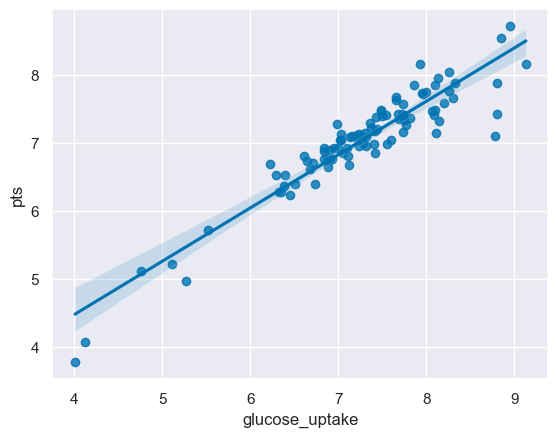

In [11]:
sns.regplot(data=all_data, x="glucose_uptake", y="pts")
plt.show()

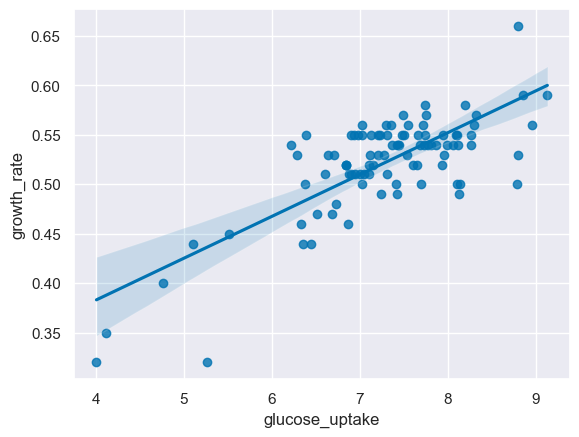

In [13]:
sns.regplot(data=all_data, x="glucose_uptake", y="growth_rate")
plt.show()

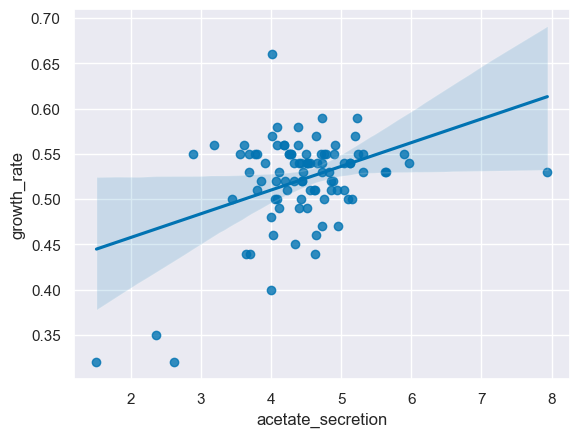

In [14]:
sns.regplot(data=all_data, x="acetate_secretion", y="growth_rate")
plt.show()

(94, 94)


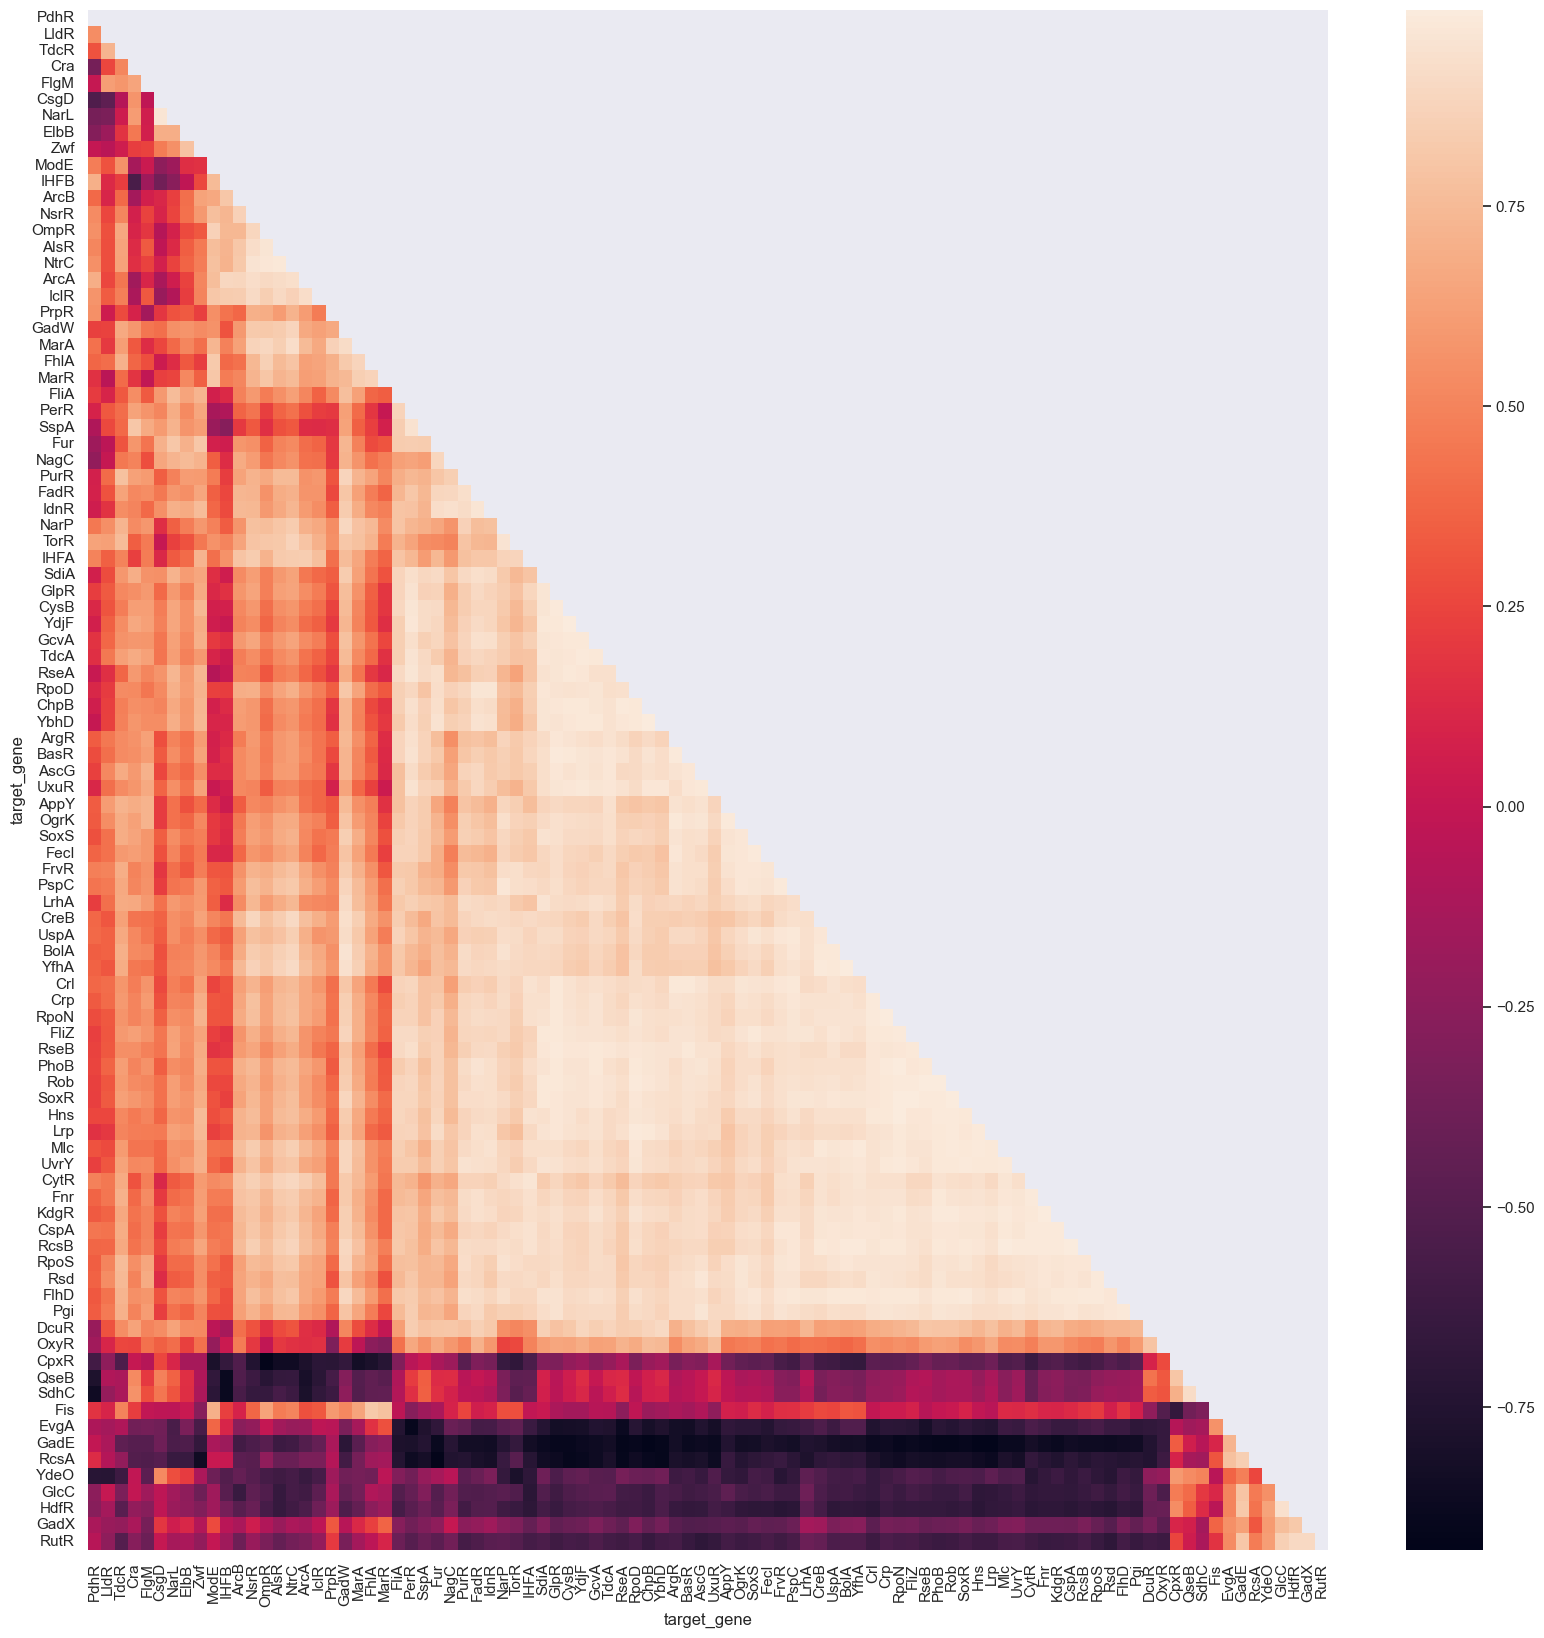

In [18]:
corr_mat_genes = all_data_norm.iloc[ordered_genes_indices].T.corr()
mask = np.triu(np.ones_like(all_data_norm.T.corr()))
print(mask.shape)
fig, ax = plt.subplots(figsize=(20, 20))
g = sns.heatmap(corr_mat_genes, xticklabels=all_data_norm.index[ordered_genes_indices], yticklabels=all_data_norm.index[ordered_genes_indices], mask=mask)
sns.set_theme(palette="colorblind")
plt.show()

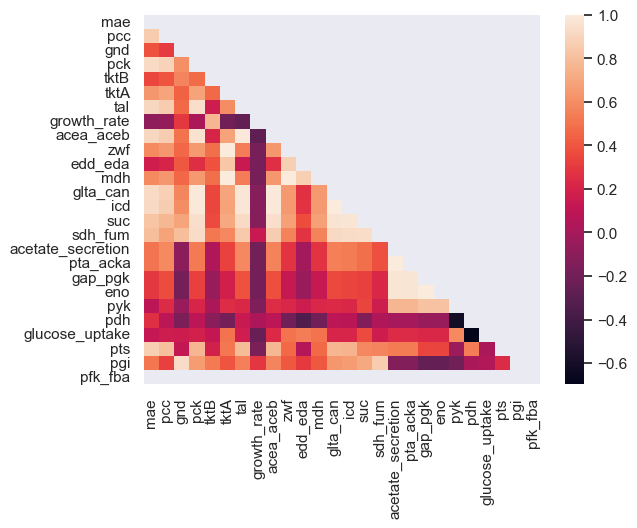

In [19]:
plt.close('all')
corr_mat_fluxes = all_data_norm.iloc[ordered_fluxes_indices].corr()
mask = np.triu(np.ones_like(corr_mat_fluxes))
sns.heatmap(corr_mat_fluxes, xticklabels=all_data.columns[ordered_fluxes_indices], yticklabels=all_data.columns[ordered_fluxes_indices], mask=mask)
sns.set_theme(palette="colorblind")
plt.show()